In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = Path("data/Houston-311-Clean.csv")
RANDOM_STATE = 42

In [2]:
df = pd.read_csv(DATA_PATH)
df.head()

/var/folders/_v/f9jlhvnd2xg9kybwfc9yh6nw0000gn/T/ipykernel_66760/2006162025.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,CASE NUMBER,NEIGHBORHOOD,DEPARTMENT,DIVISION,CASE TYPE,CREATED DATE,CLOSED DATE,LATITUDE,LONGITUDE,CATEGORY
0,12091834-101002444724,EAST LITTLE YORK / HOMESTEAD,PWE Public Works Engineering,PU Public Utilities,Fire Hydrant,2017-01-01 00:01:48,2017-01-01 11:20:02,29.856743,-95.296945,Water & Sewer
1,12091835-101002444725,NORTHSIDE/NORTHLINE,PWE Public Works Engineering,PU Public Utilities,Fire Hydrant,2017-01-01 00:07:29,2017-01-01 04:50:02,29.830449,-95.367947,Water & Sewer
2,101002444726,MID WEST,PWE Public Works Engineering,Traffic Operations,Traffic Signal Maintenance,2017-01-01 00:14:04,2017-01-01 00:23:57,29.722099,-95.539078,Traffic & Roads
3,101002444727,WASHINGTON AVENUE COALITION / MEMORIAL P,PWE Public Works Engineering,PDS Planning Development Services,MultiFamily Habitability Violation,2017-01-01 00:17:23,2017-01-04 14:01:37,29.773859,-95.402572,Other
4,12091836-101002444730,GREATER UPTOWN,PWE Public Works Engineering,PU Public Utilities,Water Leak,2017-01-01 00:30:48,2017-02-02 13:20:06,29.733522,-95.466104,Water & Sewer


In [3]:
#converting dates to datetime format
date_cols = ["CREATED DATE", "CLOSED DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")  # invalid : NaT

#converting numeric columns to numeric types
num_cols = ["LATITUDE", "LONGITUDE"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # invalid : NaN

#convert categorial columns into categories
cat_cols = ['CASE NUMBER', 'NEIGHBORHOOD', 'DEPARTMENT', 'DIVISION', 'CASE TYPE']
for col in cat_cols:
    df[col] = df[col].astype("category")

print(df.head())
print(df.shape)
print(df.dtypes)

             CASE NUMBER                              NEIGHBORHOOD  \
0  12091834-101002444724              EAST LITTLE YORK / HOMESTEAD   
1  12091835-101002444725                       NORTHSIDE/NORTHLINE   
2           101002444726                                  MID WEST   
3           101002444727  WASHINGTON AVENUE COALITION / MEMORIAL P   
4  12091836-101002444730                            GREATER UPTOWN   

                     DEPARTMENT                           DIVISION  \
0  PWE Public Works Engineering                PU Public Utilities   
1  PWE Public Works Engineering                PU Public Utilities   
2  PWE Public Works Engineering                 Traffic Operations   
3  PWE Public Works Engineering  PDS Planning Development Services   
4  PWE Public Works Engineering                PU Public Utilities   

                            CASE TYPE        CREATED DATE         CLOSED DATE  \
0                        Fire Hydrant 2017-01-01 00:01:48 2017-01-01 11:20:02

In [4]:
ts = (
    df.groupby(pd.Grouper(key="CREATED DATE", freq="M"))
      .size()
      .reset_index(name="y")
      .rename(columns={"CREATED DATE": "ds"})
      .sort_values("ds")
)
ts = ts.set_index("ds")

/var/folders/_v/f9jlhvnd2xg9kybwfc9yh6nw0000gn/T/ipykernel_66760/502603796.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="CREATED DATE", freq="M"))


In [5]:
# Fit on entire dataset
model = SARIMAX(
    ts['y'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)  # monthly seasonality
)

result = model.fit(disp=False)
print(result.summary())

/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -924.002
Date:                            Mon, 27 Oct 2025   AIC                           1858.005
Time:                                    15:55:24   BIC                           1870.721
Sample:                                01-31-2016   HQIC                          1863.141
                                     - 11-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4330      0.233      1.860      0.063      -0.023       0.889
ma.L1         -0.7053      0.204   

In [7]:
# Forecast 12 months ahead
future_steps = 12
forecast = result.get_forecast(steps=future_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Prepare forecast DataFrame
last_date = ts.index[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=future_steps, freq="M")
forecast_df = pd.DataFrame({
    "ds": future_dates,
    "forecast": forecast_mean.values,
    "lower": conf_int.iloc[:, 0].values,
    "upper": conf_int.iloc[:, 1].values
})

forecast_df.to_csv("data/sarima_forecast.csv", index=False)
forecast_df.set_index("ds", inplace=True)

/var/folders/_v/f9jlhvnd2xg9kybwfc9yh6nw0000gn/T/ipykernel_66760/1989066581.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=future_steps, freq="M")


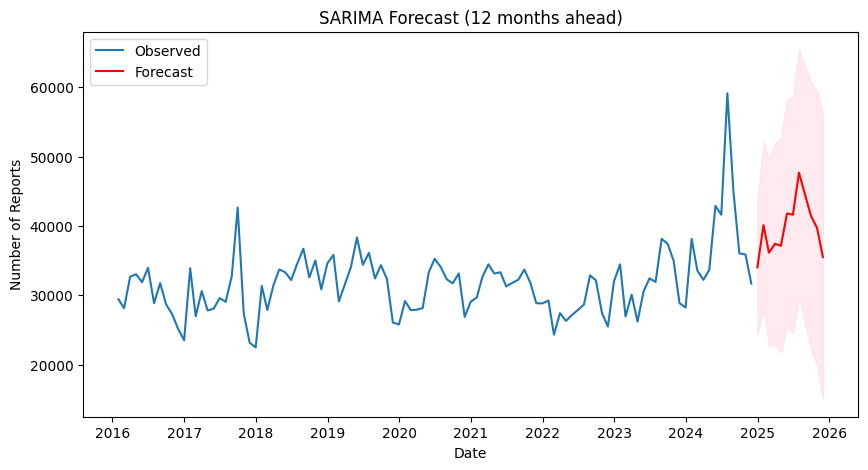

In [7]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['y'], label='Observed')
plt.plot(forecast_df.index, forecast_df['forecast'], color='red', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='pink', alpha=0.3)
plt.title(f"SARIMA Forecast ({future_steps} months ahead)")
plt.xlabel("Date")
plt.ylabel("Number of Reports")
plt.legend()
plt.show()

In [10]:
# --- Split your time series into train/test ---
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# --- Fit SARIMA on training data ---
model = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit(disp=False)

# --- Forecast for the test period ---
forecast = result.get_forecast(steps=len(test))
pred = forecast.predicted_mean

# --- Compute errors ---
mae = mean_absolute_error(test['y'], pred)
rmse = np.sqrt(mean_squared_error(test['y'], pred))
mape = np.mean(np.abs((test['y'] - pred) / test['y'])) * 100
bias = np.mean(pred - test['y'])

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Mean Bias: {bias:.2f}")

MAE:  3804.38
RMSE: 5913.14
MAPE: 10.00%
Mean Bias: -667.59


/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [ ]:
# Analyze monthly bias
test = test.copy()
test["pred"] = pred

test["month"] = test.index.month
test["error"] = test["y"] - test["pred"]

monthly_bias = (
    test.groupby("month")["error"]
        .mean()
        .round(2)
)
print(monthly_bias)


month
1      2083.17
2     -1880.53
3     -3195.80
4     -4006.58
5      1375.59
6      1855.12
7     10038.14
8      4609.98
9      -427.23
10     1031.24
11     -765.27
12    -4665.63
Name: error, dtype: float64


In [20]:
# --- Evaluate SARIMA per category ---
category_col = "NEIGHBORHOOD"
date_col = "CREATED DATE"

results = []

for cat, group in df.groupby(category_col, observed=True):
    # Aggregate monthly counts
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .sort_values(date_col)
    )

    # Skip if too few data points
    if len(ts) < 24:
        continue
    
    # Train-test split (last 6 months for testing)
    train = ts["y"][:-6]
    test = ts["y"][-6:]

    # Fit SARIMA (example order, tune as needed)
    # order = (p,d,q), seasonal_order = (P,D,Q,s)
    try:
        model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        results_model = model.fit(disp=False)

        # Forecast for test period
        forecast = results_model.get_forecast(steps=6)
        y_pred = forecast.predicted_mean

        # Compute metrics
        mae = mean_absolute_error(test, y_pred)
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = np.mean(np.abs((test - y_pred) / test)) * 100

        results.append({
            "Category": cat,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })
    except Exception as e:
        print(f"Skipping {cat} due to error: {e}")

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mojo/Documents/MyProjects/311Detector/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

                                       Category         MAE         RMSE  \
72                                  SECOND WARD   34.645243    54.164433   
83                                    SUNNYSIDE   75.322963   119.791573   
76                       SOUTH BELT / ELLINGTON   64.097625    76.776338   
36                           GREATER THIRD WARD   43.191776    60.486470   
27                                  FOURTH WARD   11.313610    16.079416   
28              GOLFCREST / BELLFORT / REVEILLE   98.283806   147.079379   
89                                     WESTBURY   45.314074    50.966630   
60                                     MINNETEX   25.283243    32.764815   
30                           GREATER FIFTH WARD   81.174836    96.449919   
40                                      GULFTON   29.236768    31.703681   
46                             KASHMERE GARDENS   36.687571    44.608994   
13                            CENTRAL SOUTHWEST  190.999538   299.617344   
33          